# Machine Learning with Random Forest

In this notebook, we will use data relative to term deposits available [here](https://www.kaggle.com/sharanmk/bank-marketing-term-deposit). Information about the potential customer (age, job, ...) and about how the current and the previous campaign was conducted is provided in order to find key features for the best subscription ratio.

In the first part of this notebook, data visualization is used to determine the category of people to target. In the second part, a Random Forest classifier is trained to predict if the client will subscribe to a term deposit or not from his profile and the campaign information.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# Data

The dataset contains the following features :
* 'age' : Age of the customer
* 'job' : Job of the customer
* 'marital' : Marital status of the customer ('divorced', 'married', 'single')
* 'education' : Education level ('primary', 'secondary', 'tertiary', 'unknown')
* 'default' : credit in default ('yes', 'no')
* 'balance' : account balance (in euros)
* 'housing' : housing loan ('yes', 'no')
* 'loan' : personal loan ('yes', 'no')
* 'contact' : contact communication type ('cellular', 'telephone', 'unknown')
* 'day' : last contact day ('mon', 'tue', ...)
* 'month' : last contact month ('jan', 'feb', ...)
* 'duration' : last contact duration (in seconds), should no be included
* 'campaign' : number of contacts during this campaign
* 'pdays' : number of days the customer was last contacted during previous campaign
* 'previous' : number of contacts during previous campaign
* 'poutcome' : outcome of previous campaign ('failure', 'other', 'success', 'unknown')
* 'y' : subscribed a term deposit ('yes', 'no')

In [3]:
bank_data = pd.read_csv('../datasets/bank-marketing/bank_customer_survey.csv')

In [4]:
bank_data = bank_data.rename(columns = {'y':'subscribed'})

In [5]:
bank_data['default'] = [1 if housing == 'yes' else 0 for housing in bank_data['default']]
bank_data['housing'] = [1 if housing == 'yes' else 0 for housing in bank_data['housing']]
bank_data['loan'] = [1 if loan == 'yes' else 0 for loan in bank_data['loan']]

In [6]:
bank_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'subscribed'],
      dtype='object')

In [7]:
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0


In [8]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age           45211 non-null int64
job           45211 non-null object
marital       45211 non-null object
education     45211 non-null object
default       45211 non-null int64
balance       45211 non-null int64
housing       45211 non-null int64
loan          45211 non-null int64
contact       45211 non-null object
day           45211 non-null int64
month         45211 non-null object
duration      45211 non-null int64
campaign      45211 non-null int64
pdays         45211 non-null int64
previous      45211 non-null int64
poutcome      45211 non-null object
subscribed    45211 non-null int64
dtypes: int64(11), object(6)
memory usage: 5.9+ MB


# Exploratory Data Analysis

To determine whether or not a customer will subscribe a term deposit, we will first analyse the type of job they do. 

Text(0, 0.5, 'Count')

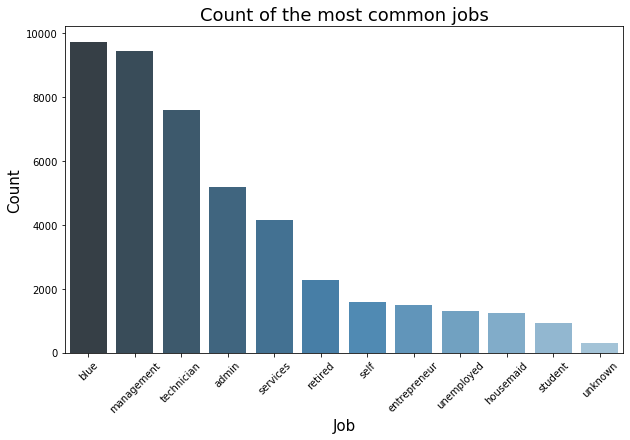

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(x = 'job', data = bank_data, order = bank_data['job'].value_counts().index, palette='Blues_d')
plt.title('Count of the most common jobs', fontsize=18)
plt.xticks(rotation=45)
plt.xlabel('Job', fontsize=15)
plt.ylabel('Count', fontsize=15)

Most people registered in the database are either blue-collars, managers or technicians. Students are obviously the less represented as it is quite unlikely they have enough money to invest. But what job is the most likely to subscribe a term deposit ?

In [11]:
ratio_job = bank_data[['job', 'subscribed']].groupby(['job']).mean().reset_index()

Text(0, 0.5, 'Subscribed')

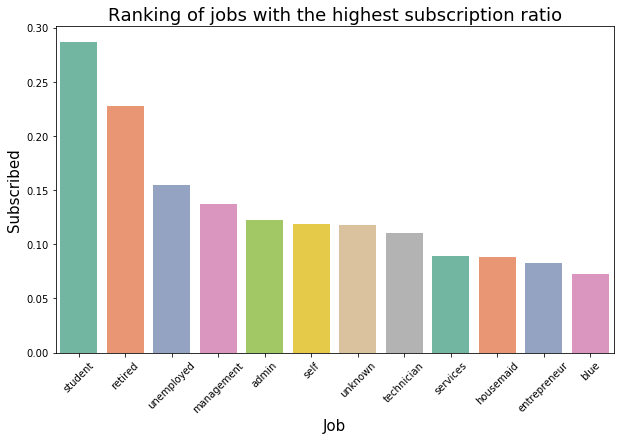

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(x = 'job', y = 'subscribed', data = ratio_job, order = ratio_job.sort_values(by=['subscribed'], ascending=False)['job'], palette='Set2')
plt.title('Ranking of jobs with the highest subscription ratio', fontsize=18)
plt.xticks(rotation=45)
plt.xlabel('Job', fontsize=15)
plt.ylabel('Subscribed', fontsize=15)

Students have the highest subscription ratio but the low number of students may no be representative. Let's explore their education level and see if it correlates with their subscription

In [13]:
loan_df = bank_data[['job', 'loan', 'housing']].groupby('job').mean().reset_index()
loan_df = loan_df.sort_values(by=['loan'], ascending=False)

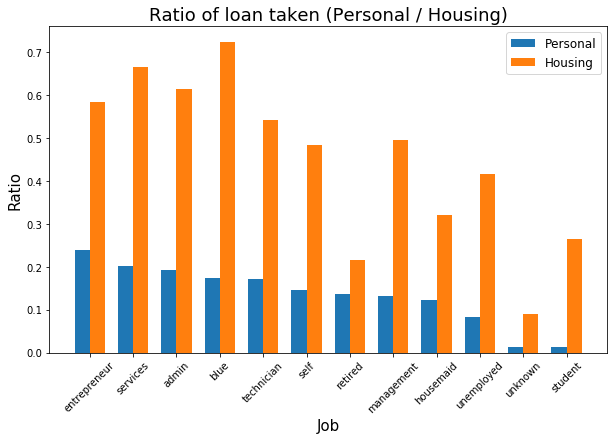

In [14]:
plt.figure(figsize=(10, 6))

ind = np.arange(len(loan_df))
width = .35

plt.bar(ind, loan_df['loan'], width, label='Personal')
plt.bar(ind+width, loan_df['housing'], width, label='Housing')

plt.title('Ratio of loan taken (Personal / Housing)', fontsize=18)
plt.xlabel('Job', fontsize=15)
plt.ylabel('Ratio', fontsize=15)

plt.xticks(ind + width / 2, loan_df['job'], rotation=45)
plt.legend(loc='best', prop={'size': 12})
plt.show()

Student may not be the richest socio-professional category but it is the one with the least loan taken and among the one with the least housing loan taken. The same applies to retirees who invest more in term deposits than take loans. Knowing that people who take out a loan can't be considered as having a job, we will see if it reflects on their balance account.

([<matplotlib.axis.XTick at 0x1e8f0c2bac8>,
 <a list of 2 Text xticklabel objects>)

<Figure size 720x432 with 0 Axes>

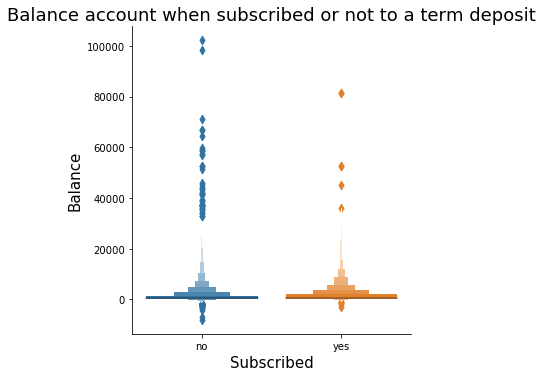

In [15]:
plt.figure(figsize=(10, 6))
sns.catplot(x='subscribed', y='balance', data=bank_data, kind='boxen')
plt.title('Balance account when subscribed or not to a term deposit', fontsize=18)
plt.xlabel('Subscribed', fontsize=15)
plt.ylabel('Balance', fontsize=15)
plt.xticks([0, 1], ['no', 'yes'])

In [16]:
bank_data['age_range'] = pd.qcut(bank_data['age'], q=8)

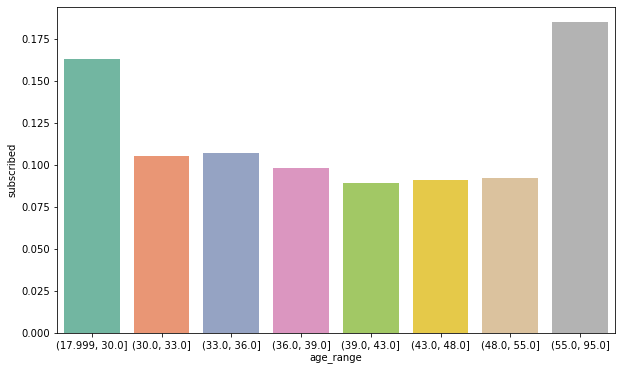

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x='age_range', y='subscribed', data=bank_data, ci = None, palette='Set2')

By taking age groups with uniform distribution, we can see as expected that people who are the most likely to subscribe to term deposits are the youngest and the oldest. Indeed, we previously saw that students and retirees were the ideal target. Otherwise, people younger than 30 are also slightly more likely to subscribe.

# Random Forest

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV

In [19]:
bank_data = bank_data.drop(['age_range'], axis=1)

### Encoding

In [20]:
bank_data = pd.concat([bank_data, pd.get_dummies(bank_data['job'])], sort=True, axis=1).drop(['job'], axis=1)
bank_data = pd.concat([bank_data, pd.get_dummies(bank_data['marital'])], sort=True, axis=1).drop(['marital'], axis=1)
bank_data = pd.concat([bank_data, pd.get_dummies(bank_data['education'])], sort=True, axis=1).drop(['education'], axis=1)
bank_data = pd.concat([bank_data, pd.get_dummies(bank_data['contact'])], sort=True, axis=1).drop(['contact'], axis=1)
bank_data = pd.concat([bank_data, pd.get_dummies(bank_data['day'])], sort=True, axis=1).drop(['day'], axis=1)
bank_data = pd.concat([bank_data, pd.get_dummies(bank_data['month'])], sort=True, axis=1).drop(['month'], axis=1)
bank_data = pd.concat([bank_data, pd.get_dummies(bank_data['poutcome'])], sort=True, axis=1).drop(['poutcome'], axis=1)

### Split train-test

In [21]:
X = bank_data.drop(['subscribed'], axis=1)
y = bank_data['subscribed']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Normalization

In [22]:
pd.options.mode.chained_assignment = None

In [23]:
age_scaler = StandardScaler().fit(X_train[['age']])
X_train['age'] = age_scaler.transform(X_train[['age']])
X_test['age'] = age_scaler.transform(X_test[['age']])

balance_scaler = StandardScaler().fit(X_train[['balance']])
X_train['balance'] = balance_scaler.transform(X_train[['balance']])
X_test['balance'] = balance_scaler.transform(X_test[['balance']])

duration_scaler = StandardScaler().fit(X_train[['duration']])
X_train['duration'] = duration_scaler.transform(X_train[['duration']])
X_test['duration'] = duration_scaler.transform(X_test[['duration']])

### Training

After preprocessing of the data (i.e. one hot encoding of categorical data and normalization of numerical data), we now train our random forest classifier. To do that, we use the 3 following constraints: :

1/ We use cross validation which splits the dataset in n folds. N-1 folds are used to train the model and the last fold is used to test it. This step is repeated until all folds are used to train and test. This technique helps to determine the robustness of the model because it is tested every time on a different set. 

2/ For the cross validation, we use stratified K-folds which allow to keep the same ratio of 0/1 categories. For cases where the dataset is unbalanced (which is the case here), it is helpful to keep a ratio similar to the original one.

3/ As for the last point, the dataset is unbalanced so we need a way to compensate that. By giving a different weight to each class, the model tends to predict the majority class often. For example, if class-0 represents 90% of the dataset and class-1 represents 10% of the dataset, the model will be penalized 10 times more when misclassifying class-0. Here, we use class_weight = 'balanced' so the weights for the classes will be proportional to their ratio in the dataset.

In [25]:
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)

rdf = RandomForestClassifier(random_state = 42, class_weight = 'balanced') 

params = {'max_depth': [5, 10, 20, 50], 
              'min_samples_split': [2, 4, 8, 12],
              'min_samples_leaf' : [1, 2, 4, 8, 10],
              'n_estimators' : [100, 300, 500]
             }

grid_clf = GridSearchCV(estimator = rdf, param_grid = params, cv = cv, n_jobs=-1, verbose=4, scoring = 'recall')
grid_clf.fit(X_train, y_train)


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed: 44.7min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 45.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=Fa

In [40]:
print(grid_clf.best_params_)

{'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [39]:
y_pred = grid_clf.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.56      0.71      7984
           1       0.21      0.86      0.33      1057

    accuracy                           0.59      9041
   macro avg       0.59      0.71      0.52      9041
weighted avg       0.88      0.59      0.67      9041



The choice of metric is always an important part of a project. Choosing the wrong metric could lead to bad results and time lost in optimizing the model for the wrong goal. 

In our case, we can't use accuracy because the dataset is too unbalanced. If we used accuracy, a naive model always predicting 0 could get a score of 88%. It sounds like a good score but the predictions would not help us at all in finding people that are the most likely to subscribe to a term deposit. 

Instead, we use recall as the score to optimize. Recall gives us information on how much 1 (subscription) we predict, whether or not we also predict 1 when the actual class is 0. Indeed, we rather want to call people that we are not sure if they are going to subscribe than calling only those who we are sure but missing opportunities.

With this metric and grid search to find the best hyperparameters for our random forest, we were able to detect up to 86% of people who are going to subscribe.